In [25]:
from IPython.display import display, HTML

# To display the image
display(HTML("<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>"))

# To display the heading and horizontal lines
display(HTML("<h1><hr style='border:none; height:3px;'><center>ML Semi-Supervised</center><hr style='border:none; height:3px;'></h1>"))

## Self-Training

   Carbon concentration (weight%)  Silicon concentration (weight%)  \
0                           0.037                             0.30   
1                           0.037                             0.30   
2                           0.037                             0.30   
3                           0.037                             0.31   
4                           0.037                             0.31   

   Manganese concentration (weight%)  Sulphur concentration (weight%)  \
0                               0.65                            0.008   
1                               0.65                            0.008   
2                               0.65                            0.008   
3                               1.03                            0.007   
4                               1.03                            0.007   

   Phosphorus concentration (weight%)  Oxygen concentration (%)  \
0                               0.012                    0.0421   
1     

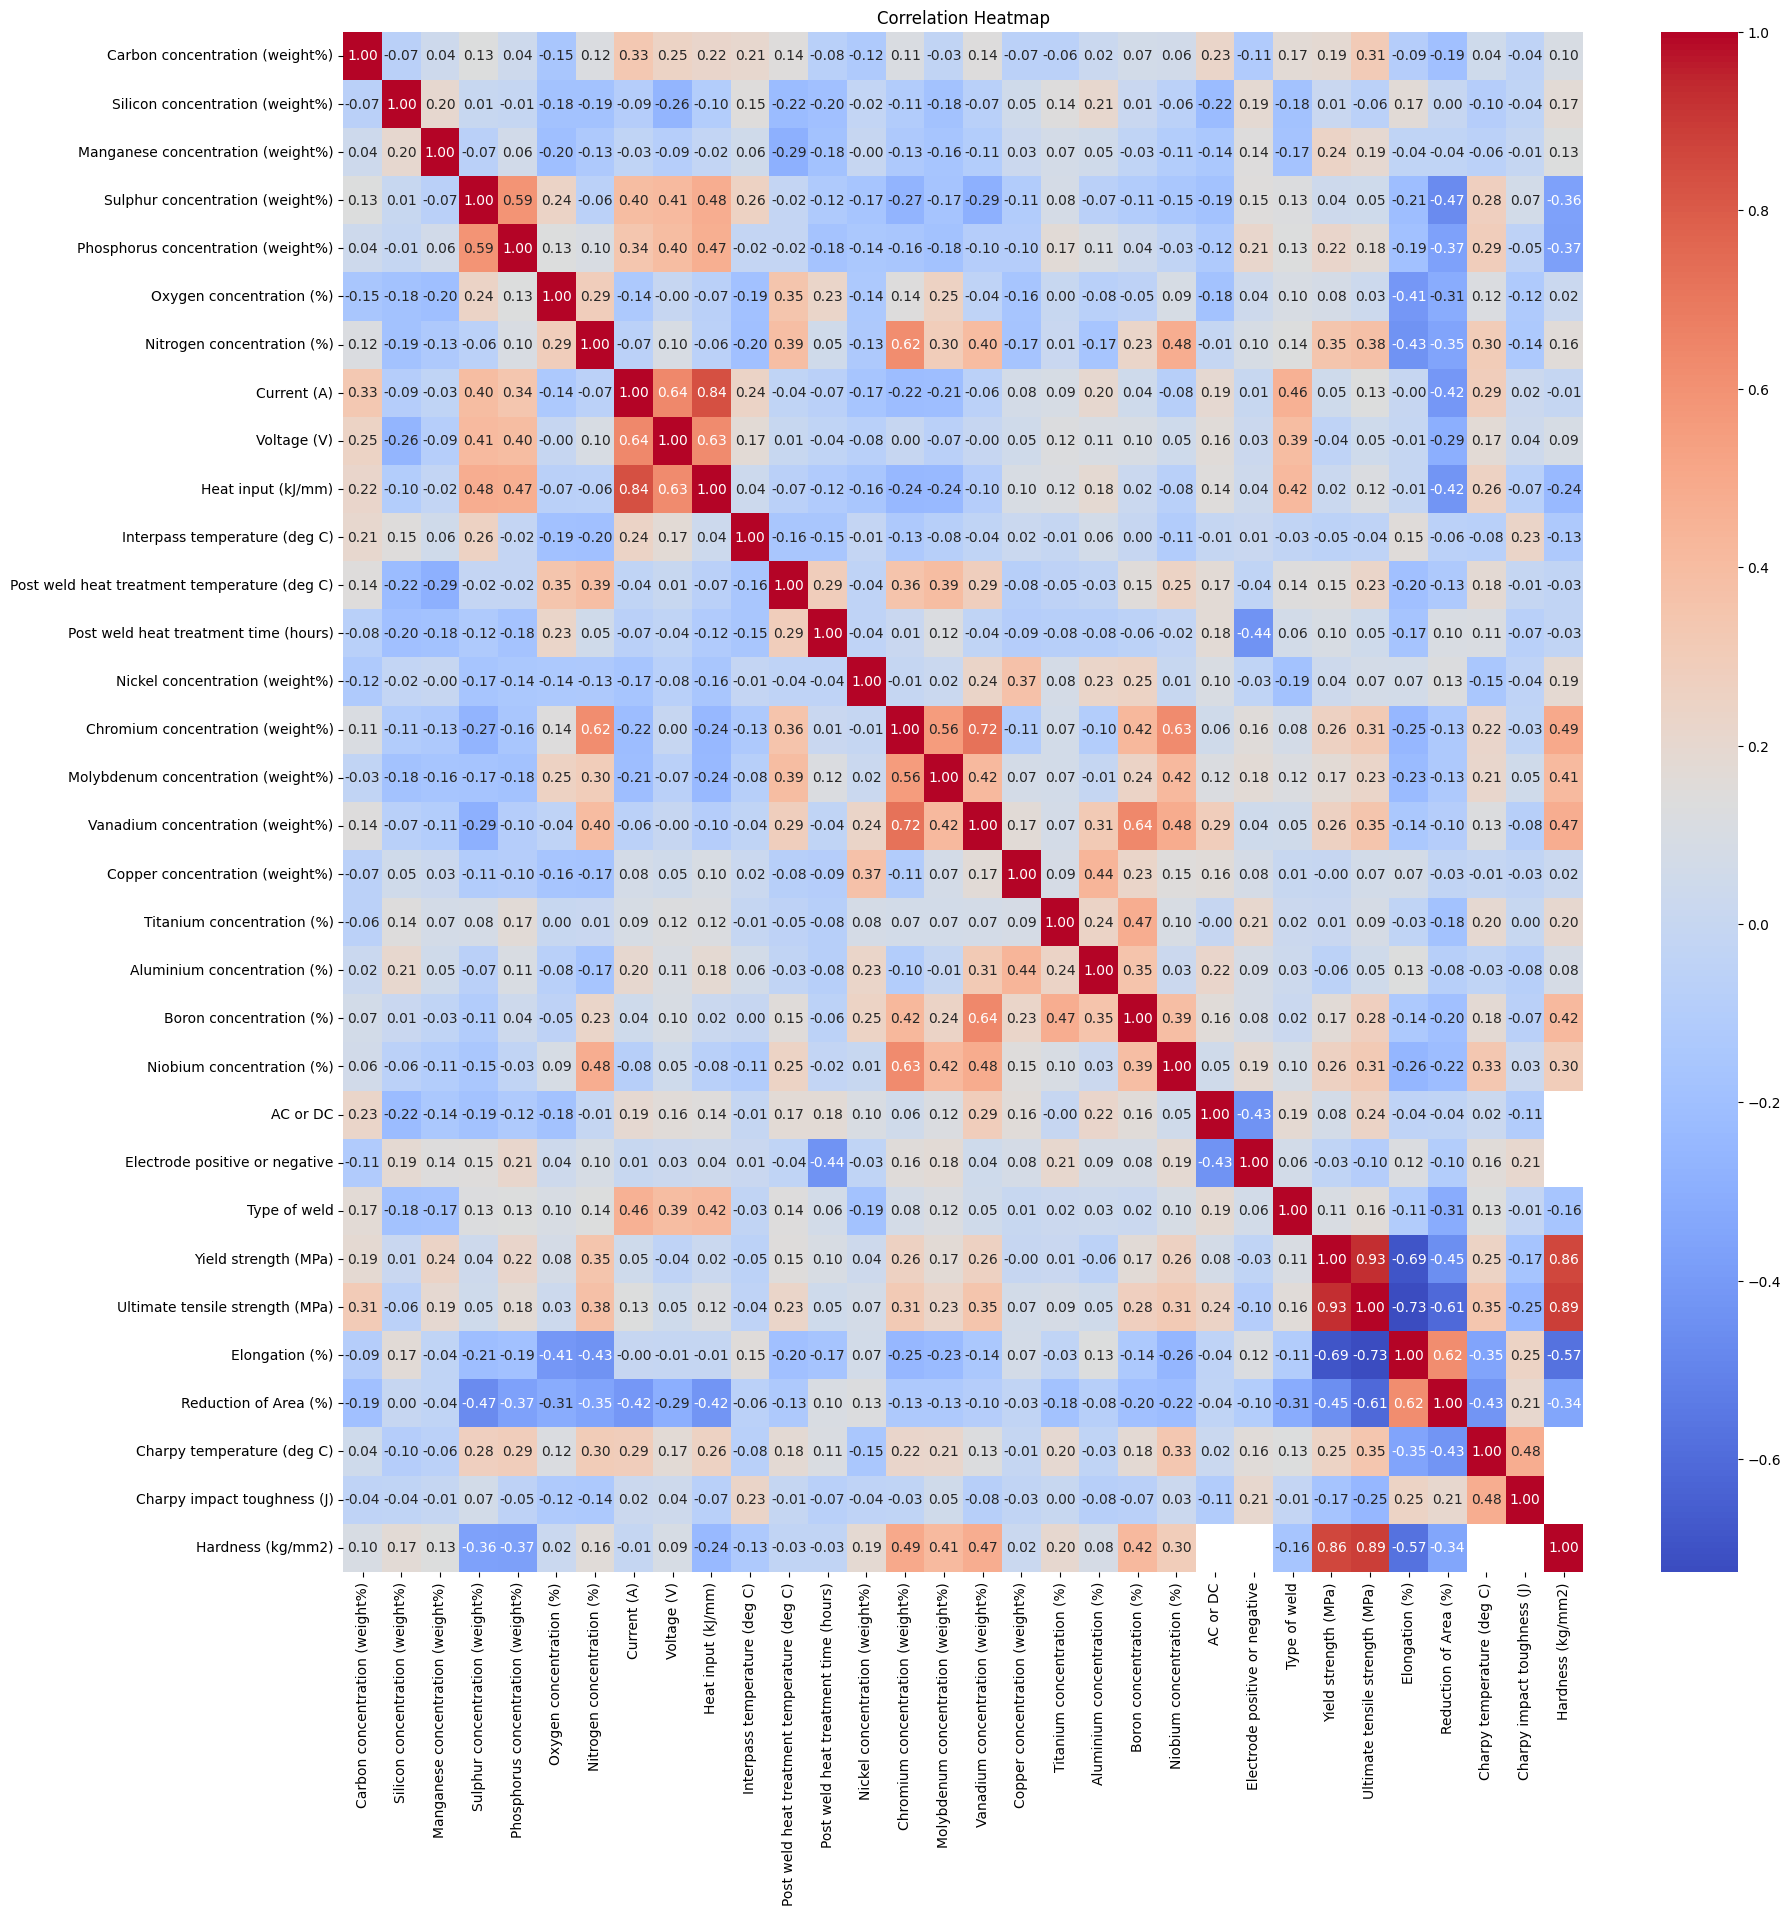

New dataset with 'target' column saved as ../4 - Dataset/new_weld_data_with_target.csv
          Method       Accuracy            AUC
0  Self-Training  0.893 ± 0.008  0.838 ± 0.016


In [15]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "../4 - Dataset/regression_weld_data_noOutliers.csv"  
weld_df = pd.read_csv(file_path)

print(weld_df.head())  
print(weld_df.info())  

weld_df = shuffle(weld_df, random_state=1)

threshold = 450  
weld_df['target'] = weld_df['Ultimate tensile strength (MPa)'].apply(lambda x: 1 if x >= threshold else 0)

X = weld_df.drop('target', axis=1)  
y = np.array(weld_df['target'])  

print(X.describe()) 

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


correlation_matrix = X.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, 
             annot=True,          
             fmt=".2f",          
             cmap='coolwarm',    
             xticklabels=X.columns, 
             yticklabels=X.columns)
plt.title('Correlation Heatmap')
plt.show()

X = X.drop(['Current (A)', 'Yield strength (MPa)', 'Hardness (kg/mm2)'], axis=1)

y_true = y.copy()

y[50:] = -1

weld_df['target'] = y

new_dataset = weld_df.copy()  

new_file_path = "../4 - Dataset/new_weld_data_with_target.csv"  
new_dataset.to_csv(new_file_path, index=False) 

print(f"New dataset with 'target' column saved as {new_file_path}")

n_splits = 5  
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

self_training_model = SelfTrainingClassifier(base_classifier, threshold=0.7)

skfolds = StratifiedKFold(n_splits=n_splits)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

for fold, (train_index, test_index) in enumerate(skfolds.split(X_imputed, y)):
    X_train = X_imputed[train_index, :]
    y_train = y[train_index]
    X_test = X_imputed[test_index, :]
    y_test = y[test_index]
    y_test_true = y_true[test_index]

    self_training_model.fit(X_train, y_train)

    y_pred = self_training_model.predict(X_test)

    scores_accuracy[fold] = accuracy_score(y_test_true, y_pred)
    scores_auc[fold] = roc_auc_score(y_test_true, y_pred)

df_results = pd.DataFrame(columns=['Method', 'Accuracy', 'AUC'])

self_training_result = {
    'Method': 'Self-Training', 
    'Accuracy': '{} ± {}'.format(round(scores_accuracy.mean(), 3), round(scores_accuracy.std(), 3)), 
    'AUC': '{} ± {}'.format(round(scores_auc.mean(), 3), round(scores_auc.std(), 3))
}

df_results = pd.concat([df_results, pd.DataFrame([self_training_result])], ignore_index=True)

print(df_results)


Fold 0, Threshold 0.40, Labeled samples: 40
Fold 1, Threshold 0.40, Labeled samples: 40
Fold 2, Threshold 0.40, Labeled samples: 40
Fold 3, Threshold 0.40, Labeled samples: 40
Fold 4, Threshold 0.40, Labeled samples: 40
Fold 0, Threshold 0.45, Labeled samples: 40
Fold 1, Threshold 0.45, Labeled samples: 40
Fold 2, Threshold 0.45, Labeled samples: 40
Fold 3, Threshold 0.45, Labeled samples: 40
Fold 4, Threshold 0.45, Labeled samples: 40
Fold 0, Threshold 0.50, Labeled samples: 40
Fold 1, Threshold 0.50, Labeled samples: 40
Fold 2, Threshold 0.50, Labeled samples: 40
Fold 3, Threshold 0.50, Labeled samples: 40
Fold 4, Threshold 0.50, Labeled samples: 40
Fold 0, Threshold 0.55, Labeled samples: 40
Fold 1, Threshold 0.55, Labeled samples: 40
Fold 2, Threshold 0.55, Labeled samples: 40
Fold 3, Threshold 0.55, Labeled samples: 40
Fold 4, Threshold 0.55, Labeled samples: 40
Fold 0, Threshold 0.60, Labeled samples: 40
Fold 1, Threshold 0.60, Labeled samples: 40
Fold 2, Threshold 0.60, Labeled 

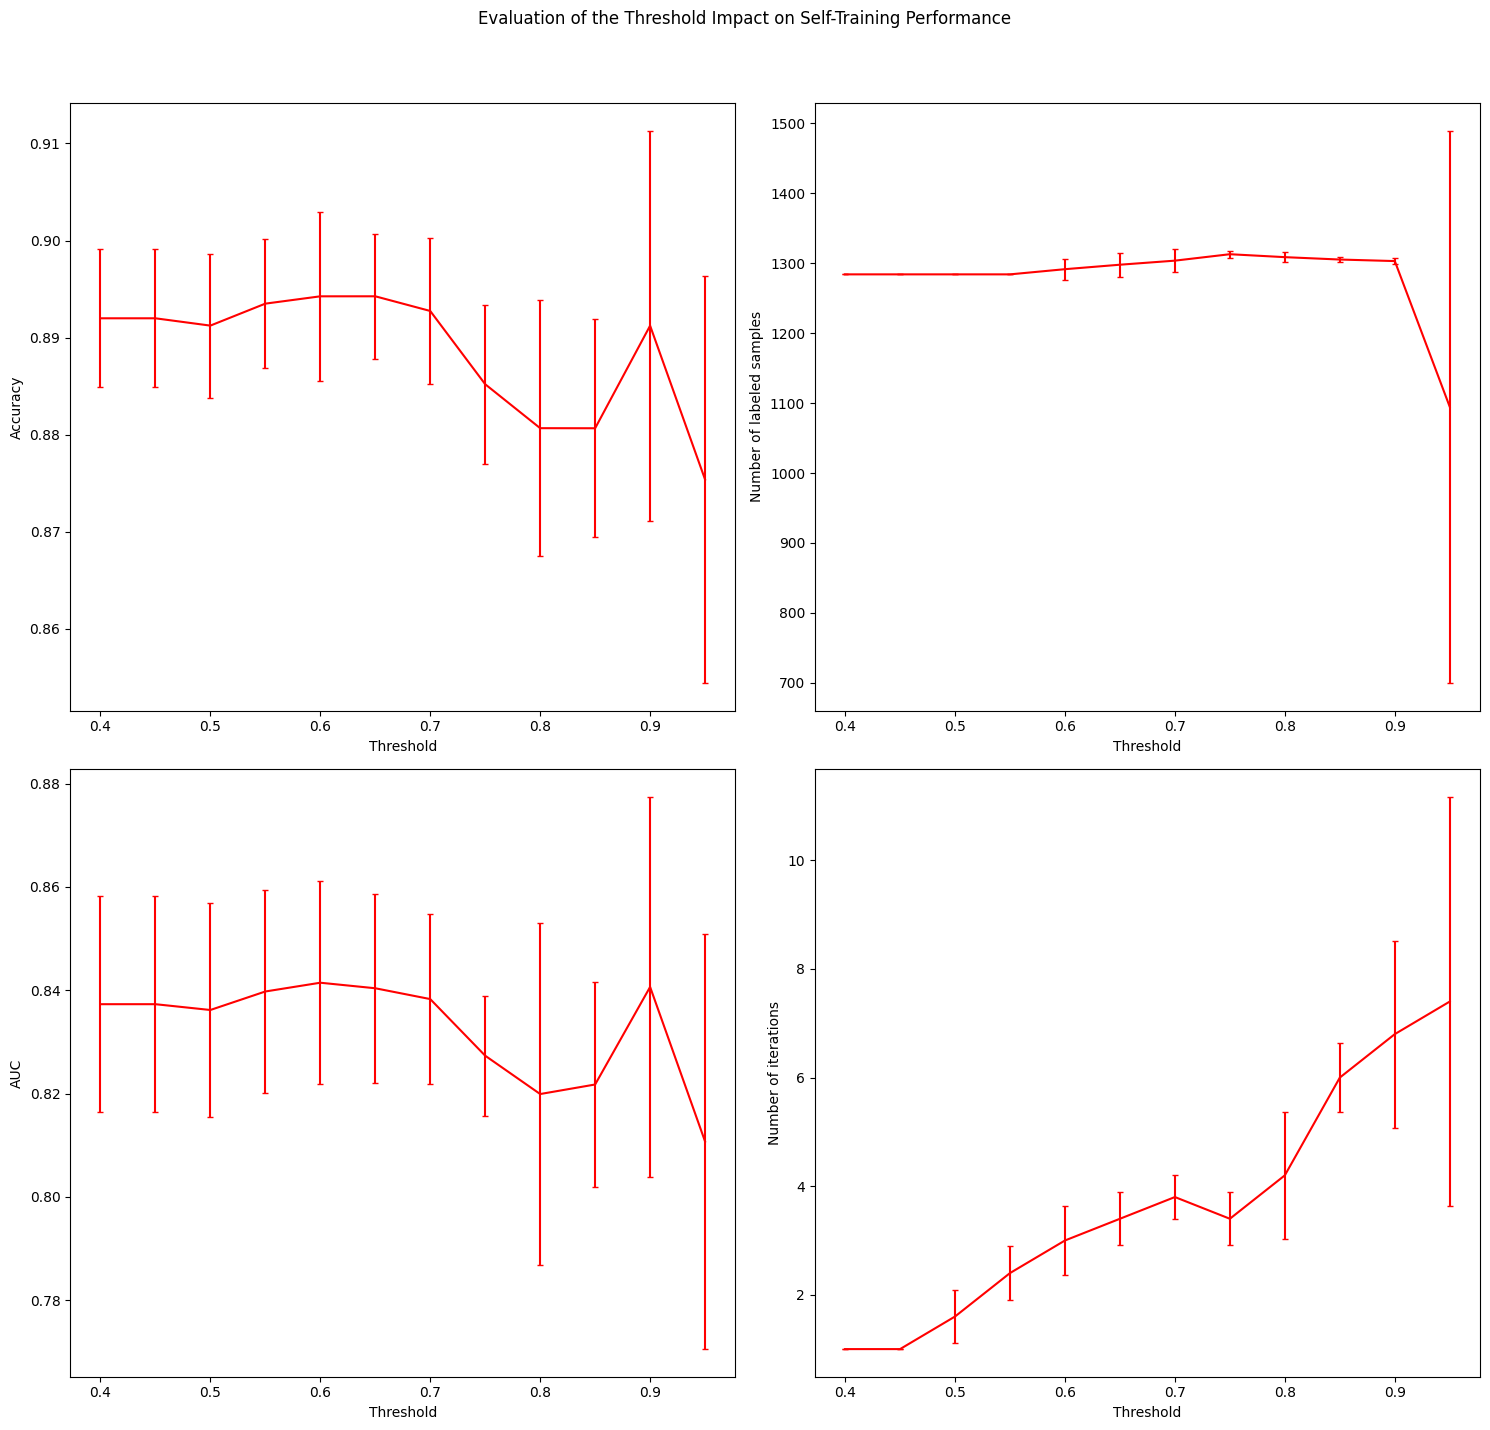

In [16]:
n_splits = 5  
total_samples = y.shape[0]
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

threshold_values = np.arange(0.4, 1.00, 0.05)
scores_accuracy = np.empty((threshold_values.shape[0], n_splits))
scores_auc = np.empty((threshold_values.shape[0], n_splits))
amount_labeled = np.empty((threshold_values.shape[0], n_splits))
max_iter = np.empty((threshold_values.shape[0], n_splits))

skfolds = StratifiedKFold(n_splits=n_splits)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

for i, threshold in enumerate(threshold_values):
    self_training_model = SelfTrainingClassifier(base_classifier, threshold=threshold)
    
    for fold, (train_index, test_index) in enumerate(skfolds.split(X_imputed, y)):
        X_train = X_imputed[train_index, :]
        y_train = y[train_index]
        X_test = X_imputed[test_index, :]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        num_labeled_samples = np.sum(y_train != -1)
        print(f"Fold {fold}, Threshold {threshold:.2f}, Labeled samples: {num_labeled_samples}")

        # Fit the model only if there are labeled samples
        if num_labeled_samples > 0:
            self_training_model.fit(X_train, y_train)
            y_pred = self_training_model.predict(X_test)

            scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
            scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)

            amount_labeled[i, fold] = total_samples - np.unique(
                self_training_model.labeled_iter_, return_counts=True)[1][0]

            max_iter[i, fold] = np.max(self_training_model.labeled_iter_)
        else:
            print(f"No labeled samples in fold {fold} for threshold {threshold:.2f}. Skipping this fold.")

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Evaluation of the Threshold Impact on Self-Training Performance')

# Plot Accuracy
ax[0, 0].errorbar(threshold_values, scores_accuracy.mean(axis=1),
                  yerr=scores_accuracy.std(axis=1),
                  capsize=2, color='red')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_xlabel('Threshold')

# Plot AUC
ax[1, 0].errorbar(threshold_values, scores_auc.mean(axis=1),
                  yerr=scores_auc.std(axis=1),
                  capsize=2, color='red')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].set_xlabel('Threshold')

# Plot Number of labeled samples
ax[0, 1].errorbar(threshold_values, amount_labeled.mean(axis=1),
                  yerr=amount_labeled.std(axis=1),
                  capsize=2, color='red')
ax[0, 1].set_ylabel('Number of labeled samples')
ax[0, 1].set_xlabel('Threshold')

# Plot Number of iterations
ax[1, 1].errorbar(threshold_values, max_iter.mean(axis=1),
                  yerr=max_iter.std(axis=1),
                  capsize=2, color='red')
ax[1, 1].set_ylabel('Number of iterations')
ax[1, 1].set_xlabel('Threshold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

## Label Propagation

In [17]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np

n_splits = 5

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

# In LabelPropagation, n_neighbors is the KNN's hyperparameter and gamma the RBF's one
lp_model = LabelPropagation(kernel='knn', n_neighbors=50, gamma=1e-6)

skfolds = StratifiedKFold(n_splits=n_splits)
imputer = SimpleImputer(strategy='mean')  

for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    y_test_true = y_true[test_index]

    # Handle NaN values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)  

    lp_model.fit(X_train, y_train)

    y_pred = lp_model.predict(X_test)
    scores_accuracy[fold] = accuracy_score(y_test_true, y_pred)
    scores_auc[fold] = roc_auc_score(y_test_true, y_pred)

print(scores_accuracy.mean())
print(scores_auc.mean())


0.7658261863922242
0.8023949699542691


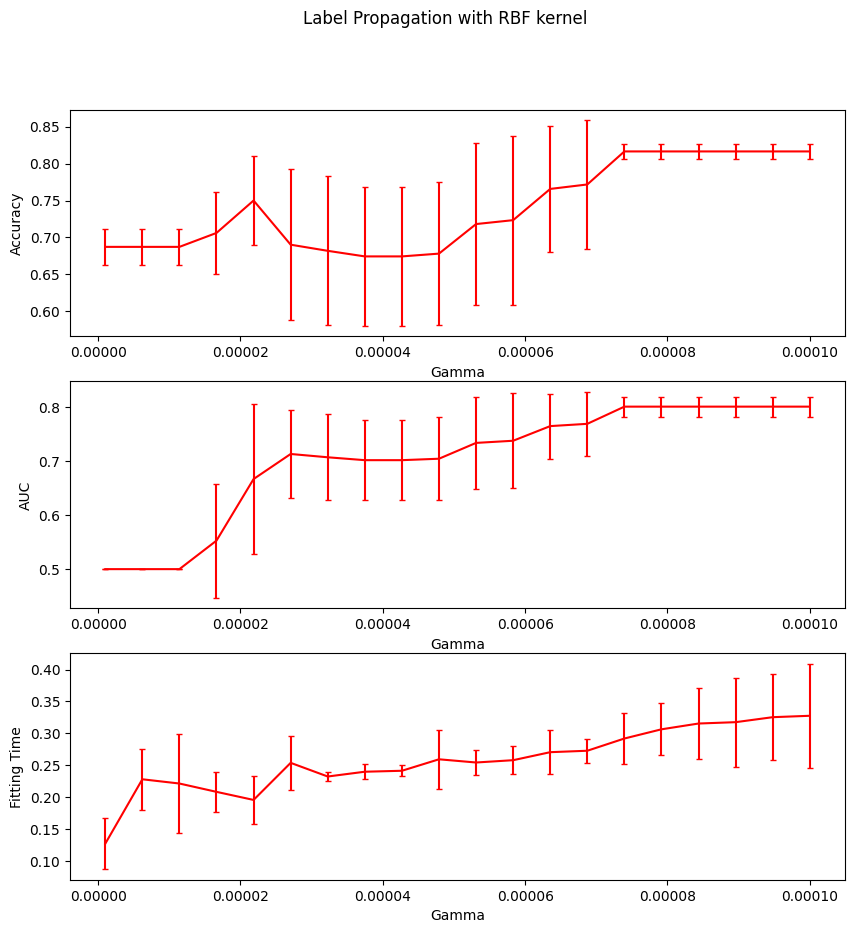

In [18]:
from time import time
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

##### RBF Kernel
n_splits = 5

gamma_values = np.linspace(1e-6, 1e-4, 20)
scores_accuracy = np.empty((gamma_values.shape[0], n_splits))
scores_auc = np.empty((gamma_values.shape[0], n_splits))
fitting_time = np.empty((gamma_values.shape[0], n_splits))

# Imputer for handling NaN values
imputer = SimpleImputer(strategy='mean')  

for i, gamma in enumerate(gamma_values):
    lp_model = LabelPropagation(kernel='rbf', gamma=gamma)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        # Handle NaN values
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)  

        t = time()
        lp_model.fit(X_train, y_train)
        fitting_time[i, fold] = time() - t 

        y_pred = lp_model.predict(X_test)
        scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
        scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)

fig, ax = plt.subplots(3, figsize=(10, 10))
fig.suptitle('Label Propagation with RBF kernel')
ax[0].errorbar(gamma_values, scores_accuracy.mean(axis=1),
               yerr=scores_accuracy.std(axis=1),
               capsize=2, color='red')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Gamma')

ax[1].errorbar(gamma_values, scores_auc.mean(axis=1),
               yerr=scores_auc.std(axis=1),
               capsize=2, color='red')
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('Gamma')

ax[2].errorbar(gamma_values, fitting_time.mean(axis=1),
               yerr=fitting_time.std(axis=1),
               capsize=2, color='red')
ax[2].set_ylabel('Fitting Time')
ax[2].set_xlabel('Gamma')
plt.show()

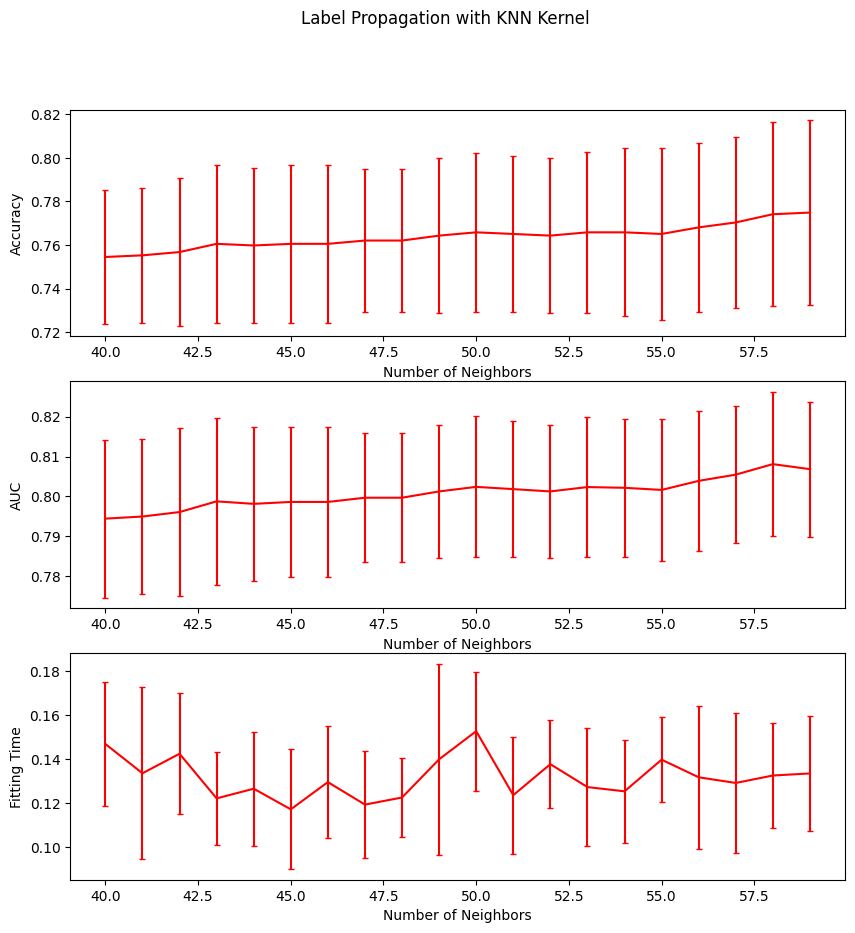

In [19]:
from time import time
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

##### KNN Kernel
n_splits = 5

neigh_values = np.arange(40, 60)
scores_accuracy = np.empty((neigh_values.shape[0], n_splits))
scores_auc = np.empty((neigh_values.shape[0], n_splits))
fitting_time = np.empty((neigh_values.shape[0], n_splits))

# Imputer for handling NaN values
imputer = SimpleImputer(strategy='mean') 

for i, n in enumerate(neigh_values):
    lp_model = LabelPropagation(kernel='knn', n_neighbors=n)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        # Handle NaN values
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)  

        t = time()
        lp_model.fit(X_train, y_train)
        fitting_time[i, fold] = time() - t 

        y_pred = lp_model.predict(X_test)
        scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
        scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)

fig, ax = plt.subplots(3, figsize=(10, 10))
fig.suptitle('Label Propagation with KNN Kernel')
ax[0].errorbar(neigh_values, scores_accuracy.mean(axis=1),
               yerr=scores_accuracy.std(axis=1),
               capsize=2, color='red')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Neighbors')

ax[1].errorbar(neigh_values, scores_auc.mean(axis=1),
               yerr=scores_auc.std(axis=1),
               capsize=2, color='red')
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('Number of Neighbors')

ax[2].errorbar(neigh_values, fitting_time.mean(axis=1),
               yerr=fitting_time.std(axis=1),
               capsize=2, color='red')
ax[2].set_ylabel('Fitting Time')
ax[2].set_xlabel('Number of Neighbors')
plt.show()


In [6]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_imputed = imputer.fit_transform(X)

parameters = {
    'kernel': ['knn', 'rbf'],
    'n_neighbors': np.arange(50, 60),  
    'gamma': np.linspace(1e-6, 1e-5, 10)  
}

lp_model = LabelPropagation()

grid = GridSearchCV(lp_model, parameters, cv=5, refit=True)

try:
    grid.fit(X_imputed, y)  
    # Print the best parameters and score
    print("Best parameters found: ", grid.best_params_)
    print("Best score: ", grid.best_score_)
except ValueError as e:
    print("ValueError:", e)


Best parameters found:  {'gamma': 1e-06, 'kernel': 'knn', 'n_neighbors': 50}
Best score:  0.02794739851343625


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

n_splits = 5

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

# Extract the best found parameters from the GridSearch
params = grid.best_params_

lp_model = LabelPropagation(kernel=params['kernel'], n_neighbors=params['n_neighbors'], gamma=params['gamma'])

y_array = np.array(y)

skfolds = StratifiedKFold(n_splits=n_splits)
for fold, (train_index, test_index) in enumerate(skfolds.split(X_imputed, y_array)):
    X_train = X_imputed[train_index, :]
    y_train = y_array[train_index]
    X_test = X_imputed[test_index, :]
    y_test = y_array[test_index]
    y_test_true = y_true[test_index]

    print("y_train content:", y_train)
    print("y_train type:", type(y_train))

    if np.any(y_train == -1): 
        pass  

    lp_model.fit(X_train, y_train)

    y_pred = lp_model.predict(X_test)
    scores_accuracy[fold] = accuracy_score(y_test_true, y_pred)
    scores_auc[fold] = roc_auc_score(y_test_true, y_pred)

results_df = pd.DataFrame({
    'Method': ['Label Propagation'],
    'Accuracy': ['{} +- {}'.format(round(scores_accuracy.mean(), 3), round(scores_accuracy.std(), 3))],
    'AUC': ['{} +- {}'.format(round(scores_auc.mean(), 3), round(scores_auc.std(), 3))]
})

df_results = pd.concat([df_results, results_df], ignore_index=True)

df_results


y_train content: [ 1  1  0 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>


,Method,Accuracy,AUC
0,Self-Training,0.893 ± 0.008,0.838 ± 0.016
1,Label Propagation,0.765 +- 0.036,0.802 +- 0.017


## Label Spreading

In [20]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np

n_splits = 5

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

# In LabelSpreading, n_neighbors is the KNN's hyperparameter and gamma the RBF's one
lp_model = LabelSpreading(kernel='knn', n_neighbors=50, gamma=1e-6)

skfolds = StratifiedKFold(n_splits=n_splits)
imputer = SimpleImputer(strategy='mean')  

for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    y_test_true = y_true[test_index]

    # Handle NaN values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)  

    lp_model.fit(X_train, y_train)

    y_pred = lp_model.predict(X_test)
    scores_accuracy[fold] = accuracy_score(y_test_true, y_pred)
    scores_auc[fold] = roc_auc_score(y_test_true, y_pred)

print("Mean Accuracy:", scores_accuracy.mean())
print("Mean AUC:", scores_auc.mean())

Mean Accuracy: 0.8421440823327616
Mean AUC: 0.8538864293030303


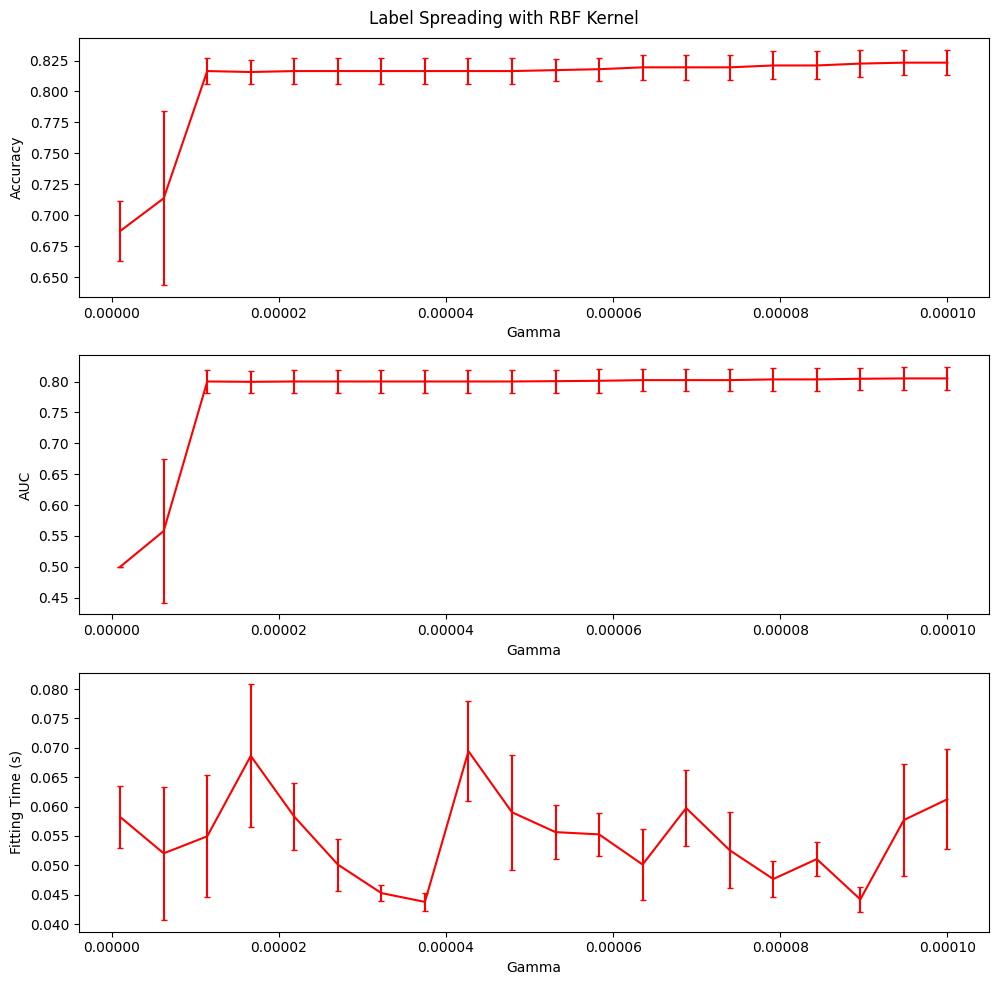

In [21]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from time import time

##### RBF Kernel

n_splits = 5

gamma_values = np.linspace(1e-6, 1e-4, 20)
scores_accuracy = np.empty((gamma_values.shape[0], n_splits))
scores_auc = np.empty((gamma_values.shape[0], n_splits))
fitting_time = np.empty((gamma_values.shape[0], n_splits))

imputer = SimpleImputer(strategy='mean')

for i, gamma in enumerate(gamma_values):
    lp_model = LabelSpreading(kernel='rbf', gamma=gamma)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X.iloc[train_index, :].copy()
        y_train = y[train_index]
        X_test = X.iloc[test_index, :].copy()
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        t = time()
        try:
            lp_model.fit(X_train, y_train)
            fitting_time[i, fold] = time() - t
        except ValueError as e:
            print(f"ValueError in fold {fold} for gamma {gamma}: {e}")
            fitting_time[i, fold] = np.nan  
            continue  

        y_pred = lp_model.predict(X_test)
        scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
        scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)

fig, ax = plt.subplots(3, figsize=(10, 10))
fig.suptitle('Label Spreading with RBF Kernel')

# Accuracy Plot
ax[0].errorbar(gamma_values, scores_accuracy.mean(axis=1),
               yerr=scores_accuracy.std(axis=1),
               capsize=2, color='red')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Gamma')

# AUC Plot
ax[1].errorbar(gamma_values, scores_auc.mean(axis=1),
               yerr=scores_auc.std(axis=1),
               capsize=2, color='red')
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('Gamma')

# Fitting Time Plot
ax[2].errorbar(gamma_values, fitting_time.mean(axis=1),
               yerr=fitting_time.std(axis=1),
               capsize=2, color='red')
ax[2].set_ylabel('Fitting Time (s)')
ax[2].set_xlabel('Gamma')

plt.tight_layout()
plt.show()


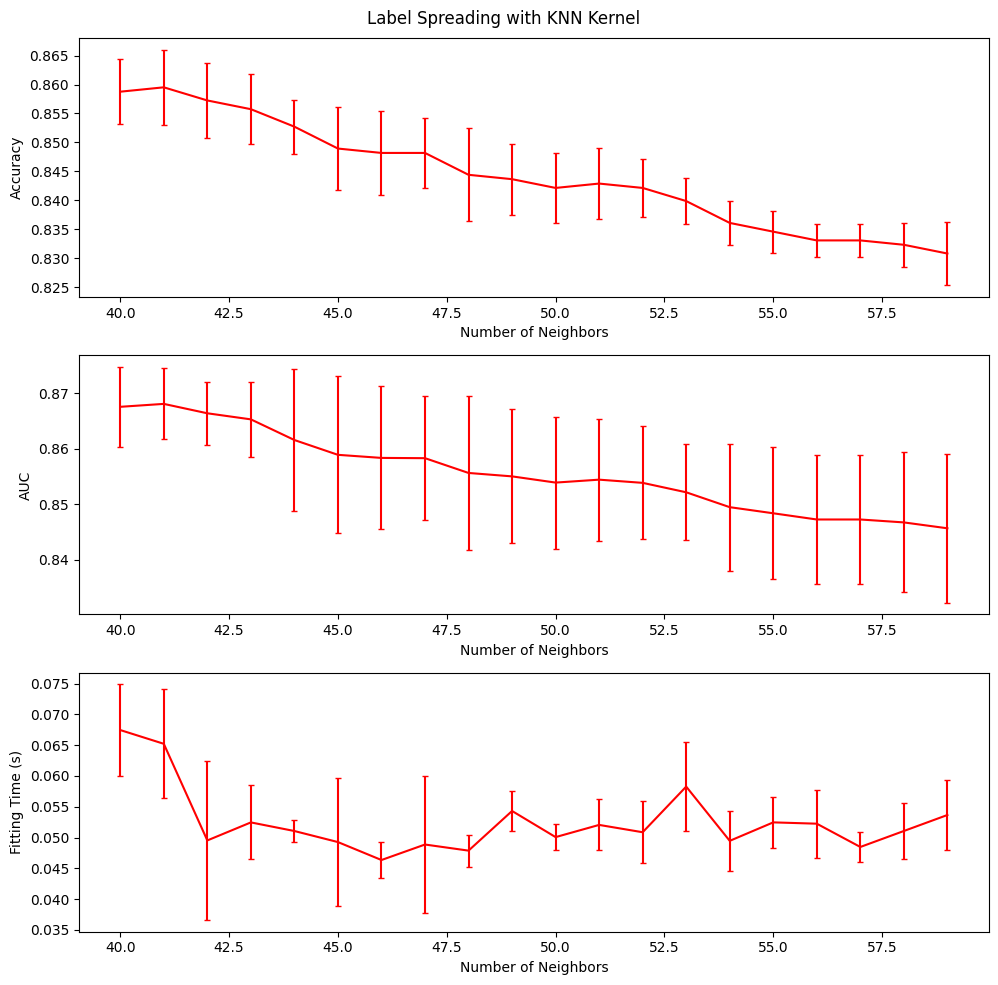

In [22]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from time import time

##### KNN Kernel

n_splits = 5

neigh_values = np.arange(40, 60)
scores_accuracy = np.empty((neigh_values.shape[0], n_splits))
scores_auc = np.empty((neigh_values.shape[0], n_splits))
fitting_time = np.empty((neigh_values.shape[0], n_splits))

imputer = SimpleImputer(strategy='mean')

for i, n in enumerate(neigh_values):
    lp_model = LabelSpreading(kernel='knn', n_neighbors=n)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X.iloc[train_index, :].copy()
        y_train = y[train_index]
        X_test = X.iloc[test_index, :].copy()
        y_test = y[test_index]
        y_test_true = y_true[test_index]
        
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        t = time()
        try:
            lp_model.fit(X_train, y_train)
            fitting_time[i, fold] = time() - t 
        except ValueError as e:
            print(f"ValueError in fold {fold} for neighbors {n}: {e}")
            fitting_time[i, fold] = np.nan  
            continue  

        y_pred = lp_model.predict(X_test)
        scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
        scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)

fig, ax = plt.subplots(3, figsize=(10, 10))
fig.suptitle('Label Spreading with KNN Kernel')

# Accuracy Plot
ax[0].errorbar(neigh_values, scores_accuracy.mean(axis=1),
                yerr=scores_accuracy.std(axis=1),
                capsize=2, color='red')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Neighbors')

# AUC Plot
ax[1].errorbar(neigh_values, scores_auc.mean(axis=1),
                yerr=scores_auc.std(axis=1),
                capsize=2, color='red')
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('Number of Neighbors')

# Fitting Time Plot
ax[2].errorbar(neigh_values, fitting_time.mean(axis=1),
                yerr=fitting_time.std(axis=1),
                capsize=2, color='red')
ax[2].set_ylabel('Fitting Time (s)')
ax[2].set_xlabel('Number of Neighbors')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_imputed = imputer.fit_transform(X)

parameters = {
    'kernel': ['knn', 'rbf'],
    'n_neighbors': np.arange(50, 60),  # Only applicable when kernel='knn'
    'gamma': np.linspace(1e-6, 1e-5, 10)  # Only applicable when kernel='rbf'
}

lp_model = LabelSpreading()

grid = GridSearchCV(lp_model, parameters, cv=5, refit=True)

try:
    grid.fit(X_imputed, y)  
    # Print the best parameters and score
    print("Best parameters found: ", grid.best_params_)
    print("Best score: ", grid.best_score_)
except ValueError as e:
    print("ValueError:", e)


Best parameters found:  {'gamma': 1e-06, 'kernel': 'knn', 'n_neighbors': 50}
Best score:  0.0324757004002287


In [12]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

n_splits = 5

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

# Extract the best found parameters from the GridSearch
params = grid.best_params_

lp_model = LabelSpreading(kernel=params['kernel'], n_neighbors=params['n_neighbors'], gamma=params['gamma'])

y_array = np.array(y)

skfolds = StratifiedKFold(n_splits=n_splits)
for fold, (train_index, test_index) in enumerate(skfolds.split(X_imputed, y_array)):
    X_train = X_imputed[train_index, :]
    y_train = y_array[train_index]
    X_test = X_imputed[test_index, :]
    y_test = y_array[test_index]
    y_test_true = y_true[test_index]

    print("y_train content:", y_train)
    print("y_train type:", type(y_train))

    if np.any(y_train == -1):  
        pass  

    lp_model.fit(X_train, y_train)

    y_pred = lp_model.predict(X_test)
    scores_accuracy[fold] = accuracy_score(y_test_true, y_pred)
    scores_auc[fold] = roc_auc_score(y_test_true, y_pred)

results_df = pd.DataFrame({
    'Method': ['Label Spreading'],
    'Accuracy': ['{} +- {}'.format(round(scores_accuracy.mean(), 3), round(scores_accuracy.std(), 3))],
    'AUC': ['{} +- {}'.format(round(scores_auc.mean(), 3), round(scores_auc.std(), 3))]
})

df_results = pd.concat([df_results, results_df], ignore_index=True)

df_results


y_train content: [ 1  1  0 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>
y_train content: [ 1  0  1 ... -1 -1 -1]
y_train type: <class 'numpy.ndarray'>


,Method,Accuracy,AUC
0,Self-Training,0.893 ± 0.008,0.838 ± 0.016
1,Label Propagation,0.765 +- 0.036,0.802 +- 0.017
2,Label Spreading,0.843 +- 0.006,0.854 +- 0.011


For the welding dataset, the Self-Training method is the best because it has the highest accuracy of 0.893.